<a href="https://colab.research.google.com/github/ucalyptus/BS-Nets-Implementation-Pytorch/blob/master/Pytorch_BSNetConv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
!pip install kornia

     |████████████████████████████████| 163kB 6.9MB/s 


In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from scipy import io 
import torch.utils.data
import scipy
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
!pip install -U spectral
if not (os.path.isfile('/content/Indian_pines_corrected.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
if not (os.path.isfile('/content/Indian_pines_gt.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

     |████████████████████████████████| 194kB 2.8MB/s 
--2020-05-07 13:38:59--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M) [text/plain]
Saving to: ‘Indian_pines_corrected.mat’

Indian_pines_correc 100%[===================>]   5.68M   483KB/s    in 13s     

2020-05-07 13:39:12 (458 KB/s) - ‘Indian_pines_corrected.mat’ saved [5953527/5953527]

--2020-05-07 13:39:14--  http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1125 (1.1K) [text/plain]
Saving to: ‘Indian_pines_gt.mat’

Indian_pines_gt.mat 100%[===================>]   1.10K  --.-KB/s    in 0s   

In [0]:
import scipy.io as sio
def loadData():
    data = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
    labels = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']
    
    return data, labels

In [0]:
def padWithZeros(X, margin=2):

    ## From: https://github.com/gokriznastic/HybridSN/blob/master/Hybrid-Spectral-Net.ipynb
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):

     ## From: https://github.com/gokriznastic/HybridSN/blob/master/Hybrid-Spectral-Net.ipynb
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]), dtype=np.uint8)
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]), dtype=np.uint8)
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels


In [0]:
class HyperSpectralDataset(Dataset):
    """HyperSpectral dataset."""

    def __init__(self,data_url,label_url):
        
        self.data = np.array(scipy.io.loadmat('/content/'+data_url.split('/')[-1])[data_url.split('/')[-1].split('.')[0].lower()])
        self.targets = np.array(scipy.io.loadmat('/content/'+label_url.split('/')[-1])[label_url.split('/')[-1].split('.')[0].lower()])
        self.data, self.targets = createImageCubes(self.data,self.targets, windowSize=7)
        
        
        self.data = torch.Tensor(self.data)
        self.data = self.data.permute(0,3,1,2)
        print(self.data.shape)
        

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
      
      return self.data[idx,:,:,:] , self.targets[idx]


In [57]:
data_train = HyperSpectralDataset('Indian_pines_corrected.mat','Indian_pines_gt.mat')

train_loader = DataLoader(data_train, batch_size=16, shuffle=True)

torch.Size([10249, 200, 7, 7])


In [58]:
print(data_train.__getitem__(0)[0].shape)
print(data_train.__len__())

torch.Size([200, 7, 7])
10249


In [0]:

class BSNET_Conv(nn.Module):

    def __init__(self,):
      
        super(BSNET_Conv, self).__init__()
        self.conv1 = nn.Sequential(
        	nn.Conv2d(200,64,(3,3),1,0),
        	nn.ReLU(True))

        self.conv1_1 = nn.Sequential(
        	nn.Conv2d(200,128,(3,3),1,0),
        	nn.ReLU(True))
        self.conv1_2 = nn.Sequential(
        	nn.Conv2d(128,64,(3,3),1,0),
        	nn.ReLU(True))
        
        self.deconv1_2 = nn.Sequential(
        	nn.ConvTranspose2d(64,64,(3,3),1,0),
        	nn.ReLU(True))
        
        self.deconv1_1 = nn.Sequential(
        	nn.ConvTranspose2d(64,128,(3,3),1,0),
        	nn.ReLU(True))

        self.conv2_1 = nn.Sequential(
        	nn.Conv2d(128,200,(1,1),1,0),
        	nn.Sigmoid())
        

        self.fc1 = nn.Sequential(
        	nn.Linear(64,128),
        	nn.ReLU(True))
        self.fc2 = nn.Sequential(
        	nn.Linear(128,200),
        	nn.Sigmoid())
        self.gp=nn.AvgPool2d(5)
    
        
    def BAM(self,x):
        
        x = self.conv1(x)
        
        
        x = self.gp(x)
        
        
        x = x.view(-1,64)
        
        x = self.fc1(x)
        
        x = self.fc2(x)
        
        x = x.view(-1,1,1,200)
        x = x.permute(0,3,1,2)
        
        return x

    def RecNet(self,x):

      x = self.conv1_1(x)
      
      x = self.conv1_2(x)
      
      x = self.deconv1_2(x)
      
      x = self.deconv1_1(x)
      
      x = self.conv2_1(x)
      
      return x
      
      

    def forward(self,x):
      
      BRW = self.BAM(x)
      
      x = x*BRW
      ret = self.RecNet(x)
      
      return ret


       
model = BSNET_Conv().to(device)


In [60]:
from torchsummary import summary
summary(model,(200,7,7),batch_size=16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [16, 64, 5, 5]         115,264
              ReLU-2             [16, 64, 5, 5]               0
         AvgPool2d-3             [16, 64, 1, 1]               0
            Linear-4                  [16, 128]           8,320
              ReLU-5                  [16, 128]               0
            Linear-6                  [16, 200]          25,800
           Sigmoid-7                  [16, 200]               0
            Conv2d-8            [16, 128, 5, 5]         230,528
              ReLU-9            [16, 128, 5, 5]               0
           Conv2d-10             [16, 64, 3, 3]          73,792
             ReLU-11             [16, 64, 3, 3]               0
  ConvTranspose2d-12             [16, 64, 5, 5]          36,928
             ReLU-13             [16, 64, 5, 5]               0
  ConvTranspose2d-14            [16, 12

In [0]:
top = 25

In [67]:
import skimage
import kornia
global bsnlist
ssim = kornia.losses.SSIM(5, reduction='none')
psnr = kornia.losses.PSNRLoss(2500)
from skimage import measure
ssim_list = []
psnr_list = []
l1_list = []
channel_weight_list = []
def train(epoch):    
    model.train()
    ENTROPY = torch.zeros(200)

    for batch_idx, (data, __) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output =  model(data)
        loss = F.l1_loss(output,data)
        loss.backward()
        optimizer.step()
        D = output.detach().cpu().numpy()
        for i in range(0,200):

          ENTROPY[i]+=skimage.measure.shannon_entropy(D[:,i,:,:])
        
        if batch_idx % (0.5*len(train_loader)) == 0:



            L1 = loss.item()
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),L1))
            l1_list.append(L1)
            ssim_val = torch.mean(ssim(data,output))
            print("SSIM: {}".format(ssim_val))
            ssim_list.append(ssim_val)
            psnr_val = psnr(data,output)
            print("PSNR: {}".format(psnr_val))
            psnr_list.append(psnr_val)
        
        
    ENTROPY = np.array(ENTROPY)
    bsnlist = np.asarray(ENTROPY.argsort()[-top:][::-1])
    print('Top {} bands with Entropy ->'.format(top),list(bsnlist))
    
    


for epoch in range(0, 50):
    train(epoch)
    

Train Epoch: 0 [0/10249 (0%)]	Loss: 119.333038
SSIM: 0.4999999403953552
PSNR: 24.984569549560547
Top 25 bands with Entropy -> [32, 80, 97, 43, 72, 151, 134, 71, 31, 7, 92, 95, 190, 36, 10, 15, 44, 48, 3, 4, 37, 159, 87, 26, 33]
Train Epoch: 1 [0/10249 (0%)]	Loss: 117.300705
SSIM: 0.4999999403953552
PSNR: 25.04174041748047
Top 25 bands with Entropy -> [32, 80, 97, 43, 72, 151, 134, 71, 7, 92, 95, 31, 190, 36, 10, 15, 4, 44, 48, 87, 3, 159, 197, 26, 33]
Train Epoch: 2 [0/10249 (0%)]	Loss: 115.751762
SSIM: 0.49999991059303284
PSNR: 25.083580017089844
Top 25 bands with Entropy -> [32, 80, 97, 43, 72, 151, 71, 134, 7, 92, 95, 31, 190, 10, 36, 4, 15, 87, 48, 3, 44, 197, 159, 26, 33]
Train Epoch: 3 [0/10249 (0%)]	Loss: 118.767014
SSIM: 0.49999991059303284
PSNR: 24.94957733154297
Top 25 bands with Entropy -> [32, 80, 97, 43, 72, 151, 71, 134, 7, 92, 31, 95, 190, 10, 4, 36, 87, 15, 3, 48, 197, 159, 44, 26, 33]
Train Epoch: 4 [0/10249 (0%)]	Loss: 119.308762
SSIM: 0.49999991059303284
PSNR: 25.005

In [0]:
bsnlist = [80, 97, 43, 71, 72, 7, 92, 151, 134, 87, 100, 15, 10, 84, 95, 38, 106, 122, 3, 34, 37, 48, 36, 86, 190]

In [69]:
x,xx,xxx = psnr_list,ssim_list,l1_list
print(len(x)),print(len(xx)),print(len(xxx))
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

50
50
50


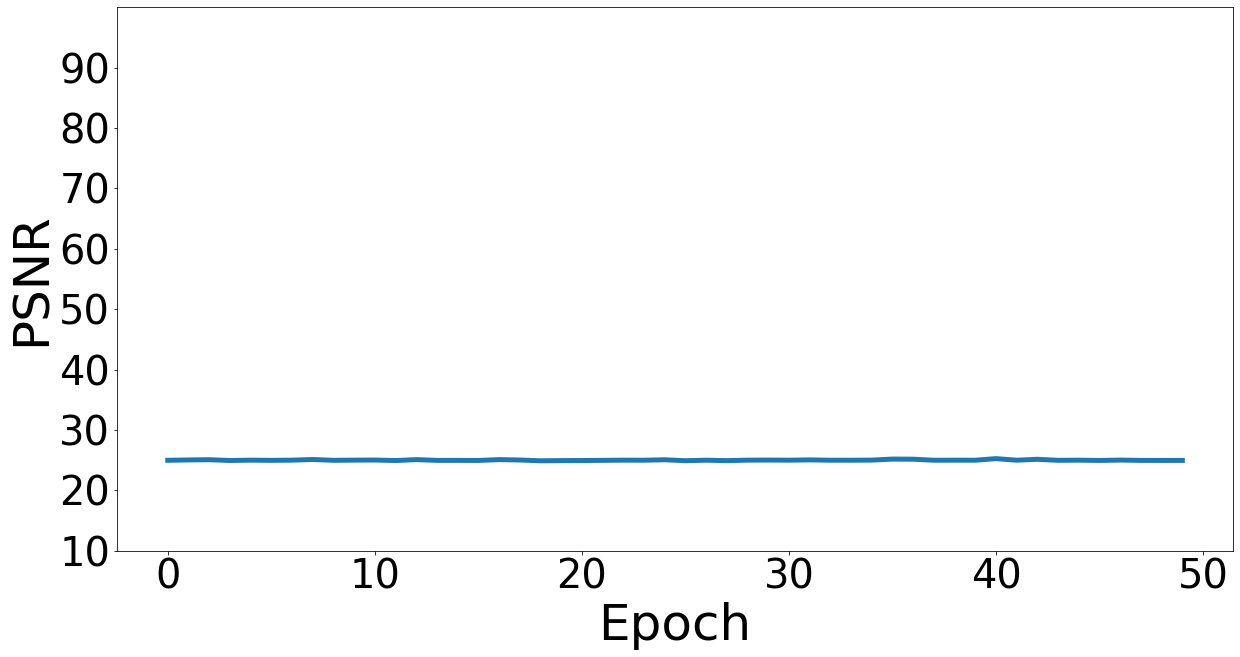

In [70]:
plt.figure(figsize=(20,10))
plt.xlabel('Epoch',fontsize=50)
plt.ylabel('PSNR',fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(np.arange(0,100 , 10.0),fontsize=40)
plt.ylim(10,100)
plt.plot(x,linewidth=5.0)
plt.savefig('PSNR-IN.pdf')
plt.show()



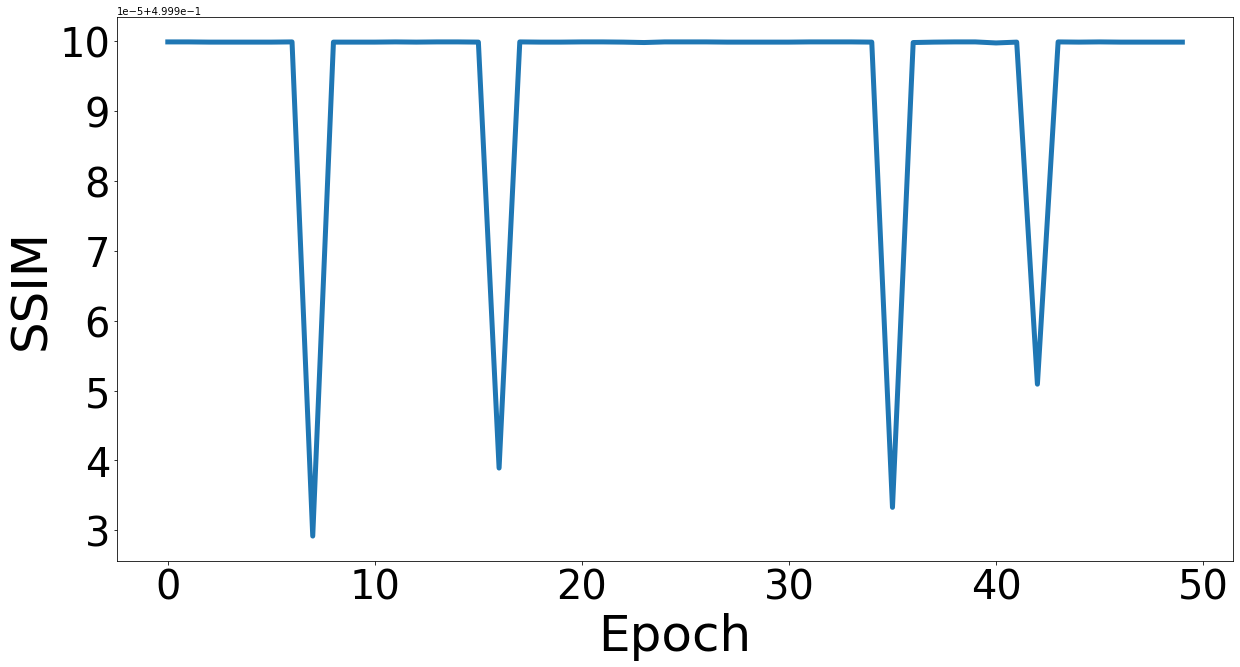

In [71]:
plt.figure(figsize=(20,10))
plt.xlabel('Epoch',fontsize=50)
plt.ylabel('SSIM',fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.plot(xx,linewidth=5.0)
plt.savefig('SSIM-IN.pdf')

plt.show()


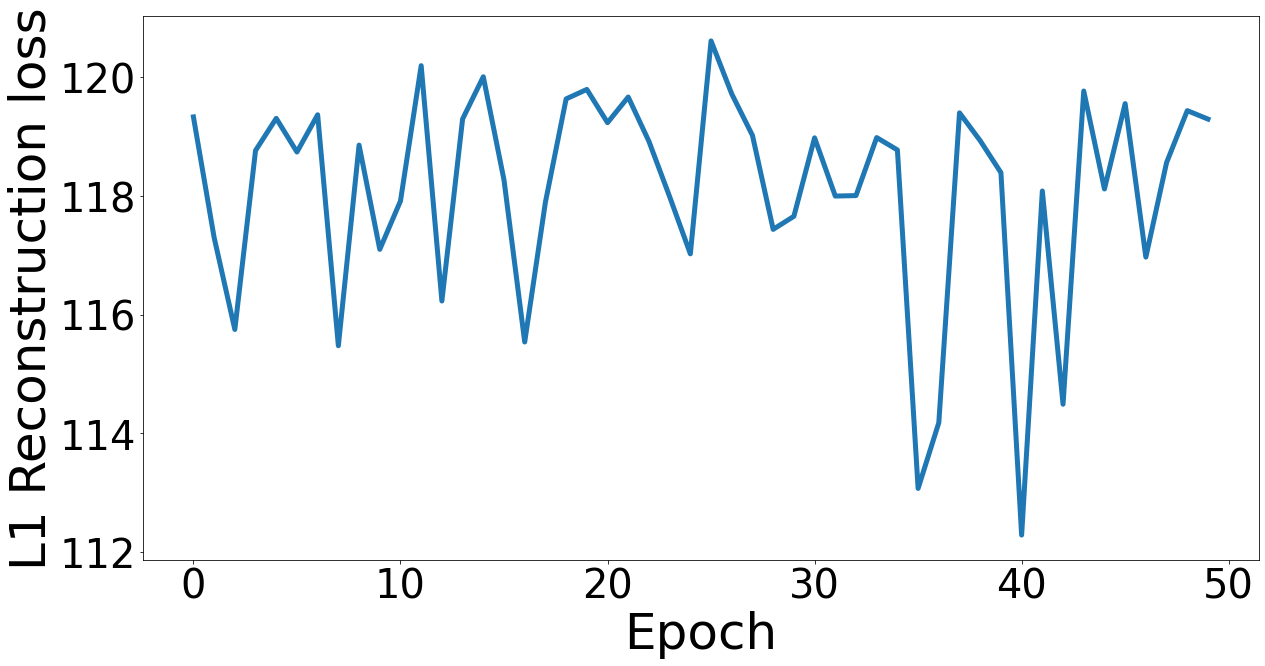

In [72]:
plt.figure(figsize=(20,10))
plt.xlabel('Epoch',fontsize=50)
plt.ylabel('L1 Reconstruction loss',fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.plot(xxx,linewidth=5.0)
plt.savefig('L1-IN.pdf')
plt.show()



In [0]:
from scipy.stats import entropy

In [0]:
def MeanSpectralDivergence(band_subset):

  n_row, n_column, n_band = band_subset.shape
  N = n_row * n_column
  hist = []
  for i in range(n_band):
    hist_, _ = np.histogram(band_subset[:, :, i], 256)
    hist.append(hist_ / N)
  hist = np.asarray(hist)
  hist[np.nonzero(hist <= 0)] = 1e-20  
  info_div = 0  
  for b_i in range(n_band):
    for b_j in range(n_band):
      band_i = hist[b_i].reshape(-1)/np.sum(hist[b_i])
      band_j = hist[b_j].reshape(-1)/np.sum(hist[b_j])
      entr_ij = entropy(band_i, band_j)
      entr_ji = entropy(band_j, band_i)
      entr_sum = entr_ij + entr_ji
      info_div += entr_sum
  msd = info_div * 2 / (n_band * (n_band - 1))
  return msd


In [0]:
def MeanSpectralAngle(band_subset):
    """
    Spectral Angle (SA) is defined as the angle between two bands.
    We use Mean SA (MSA) to quantify the redundancy among a band set.
    i-th band B_i, and j-th band B_j,
    SA = arccos [B_i^T * B_j / ||B_i|| * ||B_j||]
    MSA = 2/n*(n-1) * sum(SA_ij)
    Ref:
    [1]	GONG MAOGUO, ZHANG MINGYANG, YUAN YUAN. Unsupervised Band Selection Based on Evolutionary Multiobjective
    Optimization for Hyperspectral Images [J]. IEEE Transactions on Geoscience and Remote Sensing, 2016, 54(1): 544-57.
    :param band_subset: with shape (n_row, n_clm, n_band)
    :return:
    """
    n_row, n_column, n_band = band_subset.shape
    spectral_angle = 0
    for i in range(n_band):
        for j in range(n_band):
            band_i = band_subset[i].reshape(-1)
            band_j = band_subset[j].reshape(-1)
            lower = np.sum(band_i ** 2) ** 0.5 * np.sum(band_j ** 2) ** 0.5
            higher = np.dot(band_i, band_j)
            if higher / lower > 1.:
                angle_ij = np.arccos(1. - 1e-16)
                # print('1-higher-lower', higher - lower)
            # elif higher / lower < -1.:
            #     angle_ij = np.arccos(1e-8 - 1.)
                # print('2-higher-lower', higher - lower)
            else:
                angle_ij = np.arccos(higher / lower)
            spectral_angle += angle_ij
    msa = spectral_angle * 2 / (n_band * (n_band - 1))
    return msa

In [0]:
import skimage
from skimage import measure
def sumentr(band_subset,X):
  nbands = len(band_subset)
  ENTROPY=np.ones(nbands)
  for i in range(0,len(band_subset)):
    ENTROPY[i]+=skimage.measure.shannon_entropy(X[:,:,band_subset[i]])
  return np.sum(ENTROPY)

 

In [0]:
def MSA(bsnlist):
  X, _ = loadData()
  print('[',end=" ")
  for a in range(2,len(bsnlist)):
    band_subset_list = []
    for i in bsnlist[:a]:
      band_subset_list.append(X[:,:,i])     
    band_subset = np.array(band_subset_list)
    band_subset = np.stack(band_subset,axis =2)
    print(MeanSpectralAngle(band_subset),end=" ")
    if a!= len(bsnlist)-1:
      print(",",end=" ")
  print(']')
    





In [0]:
def MSD(bsnlist):
  X, _ = loadData()
  print('[',end=" ")
  for a in range(2,len(bsnlist)):
    band_subset_list = []
    for i in bsnlist[:a]:
      band_subset_list.append(X[:,:,i])     
    band_subset = np.array(band_subset_list)
    band_subset = np.stack(band_subset,axis =2)
    print(MeanSpectralDivergence(band_subset),end=" ")
    if a!= len(bsnlist)-1:
      print(",",end=" ")
  print(']')
    



In [0]:
def EntropySum(bsnlist):
  X, _ = loadData()
  print('[',end=" ")
  for a in range(2,len(bsnlist)):
    band_subset_list = []
    for i in bsnlist[:a]:
      band_subset_list.append(X[:,:,i])     
    band_subset = np.array(band_subset_list)
    band_subset = np.stack(band_subset,axis =2)
    print(sumentr(bsnlist[:a],X),end=" ")
    if a!= len(bsnlist)-1:
      print(",",end=" ")
  print(']')
    


In [13]:
MSA(bsnlist)
MSD(bsnlist)
EntropySum(bsnlist)

[ 6.263858268452549 , 4.706296504129299 , 4.1844681005878 , 3.923169148254087 , 3.7675616846876774 , 3.6627470238676842 , 3.588351633539779 , 3.532659665964012 , 3.4890676231098037 , 3.4544282101572703 , 3.4259455537492873 , 3.4022773846495338 , 3.382276077067694 , 3.3650961139873132 , 3.3501176445460303 , 3.337111442721376 , 3.3256093689248165 , 3.3154048049545253 , 3.3062338323033136 , 3.2979783988622877 , 3.2905509296109567 , 3.2837519306309595 , 3.2776083307152155 ]
[ 0.3815454878000646 , 6.781090755133797 , 9.950440828878444 , 11.237053937027174 , 27.088203156192495 , 28.32426713263673 , 31.61098768365176 , 29.18215151414016 , 30.623415605281778 , 28.31521833089382 , 27.449306705475106 , 26.808790797203535 , 26.64422017203365 , 26.15949242450031 , 24.537110949551423 , 26.60549266437586 , 25.726471570464867 , 25.336850074623072 , 24.637817130631845 , 23.95399234128613 , 23.29746143739684 , 22.647506727415077 , 22.878749722275444 ]
[ 20.475831193573708 , 32.940514326670495 , 44.7034

23
23
23
23
23
23


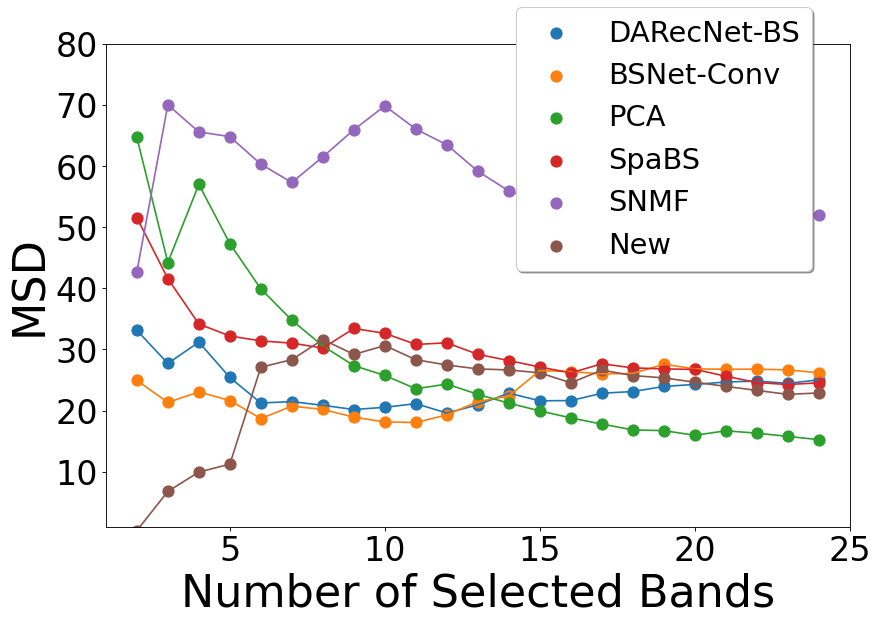

In [14]:
dabs = [ 33.12881252113703 , 27.699269748852547 , 31.189050523240567 , 25.407158521806743 , 21.23842365661258 , 21.4600299169822 , 20.86248085946583 , 20.17228040657472 , 20.53299041484558 , 21.1335634998955 , 19.59117061832842 , 20.946230004039375 , 22.843494279707382 , 21.596483466175062 , 21.633130554147392 , 22.832050045391185 , 23.112561570936894 , 23.938250673675114 , 24.27697303727743 , 24.67049003424132 , 24.818116958133697 , 24.450204537801287 , 25.019421764795172 ]
bsnetconv = [ 24.926582298710684 , 21.330938461786815 , 23.04076040826106 , 21.645181998356264 , 18.691557180047244 , 20.7226257192415 , 20.180950404677475 , 18.92119239091796 , 18.14126793229048 , 18.054941145300337 , 19.2913419518319 , 21.458442690479096 , 22.376986846120094 , 26.539316782854403 , 26.364677531292276 , 26.004356791026886 , 26.06563007931373 , 27.562615680165703 , 26.816233958923476 , 26.75423730463073 , 26.76546728344344 , 26.651876628889074 , 26.170407693767313 ]
pca = [ 64.6659495569616 , 44.206964175291155 , 56.974405048963185 , 47.303760042785385 , 39.8940534876976 , 34.768743086455515 , 30.563590015282664 , 27.347606401064958 , 25.73579551531729 , 23.562059922897653 , 24.332531206971105 , 22.65318676880641 , 21.20680313199034 , 19.950365482269632 , 18.7957381872366 , 17.785780071254095 , 16.84197341100759 , 16.71704973304585 , 15.959359012341034 , 16.69296720295007 , 16.303398054778945 , 15.775575036839665 , 15.247189808858215 ]
spabs = [ 51.546751478947485 , 41.56190968855882 , 34.1507585379382 , 32.18755647433454 , 31.393008047463585 , 31.02527459658134 , 30.212480943960397 , 33.42180148091237 , 32.627589457381625 , 30.811290451152864 , 31.07497311582388 , 29.193101794721112 , 28.174085856682574 , 27.110556610241026 , 26.16396012024104 , 27.642474793195948 , 26.97927639524588 , 26.802185442574 , 26.733570979934218 , 25.614498829087168 , 24.57496106936372 , 24.260774948635653 , 24.535411090068447 ]
snmf = [ 42.687271482734026 , 69.98650272134581 , 65.56190884814379 , 64.78830503377719 , 60.283392581094056 , 57.29725635316855 , 61.48424023193987 , 65.9111624844873 , 69.81263992889625 , 66.0216268025207 , 63.44659867282022 , 59.12927876180595 , 55.89468878602123 , 54.131703617998376 , 56.680276749080825 , 59.53217131059314 , 57.16351130033321 , 54.9461367723193 , 55.23628180002861 , 54.62510055278423 , 53.74485500301176 , 52.97448803455957 , 51.9084356071723 ]
issc = [ 18.282704191681795 , 35.29174781838125 , 33.52621667208111 , 34.7570094214297 , 34.693446545983406 , 33.8470987598166 , 42.36183874938314 , 38.34479910743488 , 38.34974051412382 , 35.28287700260462 , 32.65494379097696 , 32.312139823186655 , 30.307662525527835 , 29.98966839606608 , 29.269512799967384 , 29.912423244699333 , 29.038917745855983 , 28.929037072912795 , 28.672306590798843 , 28.505889476998565 , 28.182865736586837 , 28.759689061354372 , 28.95934175252772 ]
new = [ 0.3815454878000646 , 6.781090755133797 , 9.950440828878444 , 11.237053937027174 , 27.088203156192495 , 28.32426713263673 , 31.61098768365176 , 29.18215151414016 , 30.623415605281778 , 28.31521833089382 , 27.449306705475106 , 26.808790797203535 , 26.64422017203365 , 26.15949242450031 , 24.537110949551423 , 26.60549266437586 , 25.726471570464867 , 25.336850074623072 , 24.637817130631845 , 23.95399234128613 , 23.29746143739684 , 22.647506727415077 , 22.878749722275444 ]
NSBands = list((i for i in range(2,25)))
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
methods = [dabs,bsnetconv,pca,spabs,snmf,new]
for i in methods:  print(len(i))
markerstylelist = ["8","1","2","4","*","3","5"]
scatar = []
f = plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
for method in methods:
  PLOT = plt.plot(NSBands,method,markersize=30)
  SCATTER = plt.scatter(NSBands,method,s=100)
  scatar.append(SCATTER)
plt.xlabel('Number of Selected Bands',fontsize=40)
plt.ylabel('MSD',fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylim(1,80)
plt.xlim(1,25)
plt.legend(scatar,['DARecNet-BS','BSNet-Conv','PCA','SpaBS','SNMF','New'],loc='best',fontsize='xx-large',shadow=True,prop={'size': 26},bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
plt.show()
f.savefig("MSD-IN.pdf", bbox_inches='tight')